In [1]:
import torch
import torch.nn as nn
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as n

In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [3]:
# This is inspired by Kolmogorov-Arnold Networks but using trigonometric polynomials instead of splines coefficients
class TrigKANLayer(nn.Module):
    def __init__(self, input_dim, output_dim, degree):
        super(TrigKANLayer, self).__init__()
        self.input_dim = input_dim
        self.out_dim = output_dim
        self.degree = degree
        self.trig_coeffs = nn.Parameter(torch.empty(input_dim, output_dim, degree + 1, 2))
        nn.init.normal_(self.trig_coeffs, mean=0.0, std=1 / (input_dim * (degree + 1)))
        self.register_buffer("arange", torch.arange(0, degree + 1, 1))

    def forward(self, x):
        # View and repeat input degree + 1 times
        x = x.view((-1, self.input_dim, 1)).expand(-1, -1, self.degree + 1)
        # shape = (batch_size, input_dim, self.degree + 1)

        # Compute sine and cosine terms
        x_sin = torch.sin(x * self.arange)
        x_cos = torch.cos(x * self.arange)

        # Concatenate sine and cosine terms
        x_trig = torch.stack((x_sin, x_cos), dim=-1)
        # shape = (batch_size, input_dim, self.degree + 1, 2)

        # Compute the trigonometric interpolation
        y = torch.einsum("bidk,iodk->bo", x_trig, self.trig_coeffs)
        # shape = (batch_size, out_dim)

        y = y.view(-1, self.out_dim)
        return y

class T_KAN(nn.Module):
    def __init__(self):
        super(T_KAN, self).__init__()
        self.trigkan1 = TrigKANLayer(784, 32, 3)
        self.ln1 = nn.LayerNorm(32)
        self.trigkan2 = TrigKANLayer(32, 16,3)
        self.ln2 = nn.LayerNorm(16)
        self.trigkan3 = TrigKANLayer(16, 10, 3)

    def forward(self, x):
        x = self.trigkan1(x)
        x = self.ln1(x)
        x = self.trigkan2(x)
        x = self.ln2(x)
        x = self.trigkan3(x)
        return x

In [4]:
import torch
import torch.nn as nn
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as n
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 10



criterion = nn.CrossEntropyLoss()


def train(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    
    for idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        if isinstance(optimizer, optim.LBFGS):
            def closure():
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                loss.backward()
                return loss
            loss = optimizer.step(closure)
        else:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            loss = loss.item()
            
        total_loss += loss
        
    return total_loss / len(train_loader)

def validate(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            total_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    return total_loss / len(test_loader), correct / len(test_loader.dataset)

In [5]:
model2 = T_KAN().to(device)
total_params = sum(p.numel() for p in model2.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params}")

Total trainable parameters: 206176


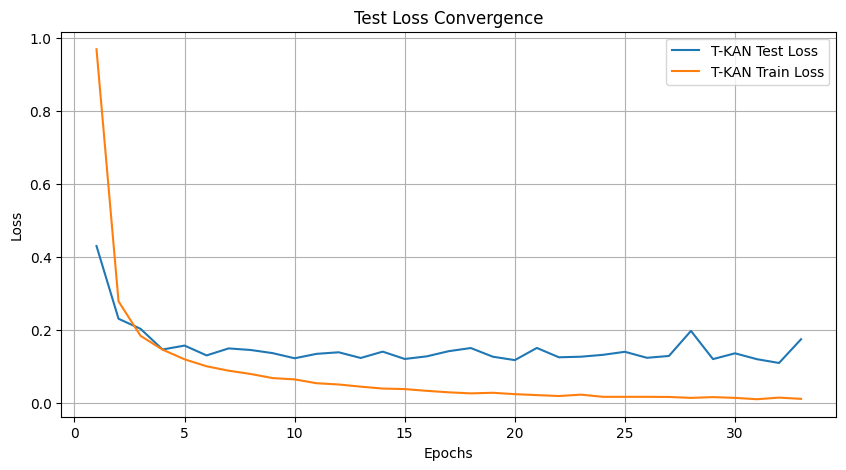

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

epochs=33

def train_and_validate(models, model_names, train_loader, test_loader, criterion, optimizers, device, epochs):
    train_losses = [[] for _ in range(len(models))]
    test_losses = [[] for _ in range(len(models))]
    best_weights = [None] * len(models)
    best_test_losses = [float('inf')] * len(models)

    for epoch in range(epochs):
        for i, (model, optimizer) in enumerate(zip(models, optimizers)):
            train_loss = train(model, train_loader, criterion, optimizer, device)
            test_loss, test_accuracy = validate(model, test_loader, criterion, device)
            train_losses[i].append(train_loss)
            test_losses[i].append(test_loss)

            if test_loss < best_test_losses[i]:
                best_test_losses[i] = test_loss
                best_weights[i] = model.state_dict()

            print(f'{model_names[i]}, Epoch {epoch+1}, Train Loss: {train_loss:.4f}, '
                  f'Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}')

    return train_losses, test_losses, best_weights


Model_Names = [ 'T-KAN']# You can add more models for comparison. 
models = [model2]# You can add more models for comparison. 
optimizers = [optim.Adam(model.parameters(), lr=0.0002) for model in models]

train_losses, test_losses, best_weights = train_and_validate(models, Model_Names, train_loader, test_loader, criterion, optimizers, device, epochs)

plt.figure(figsize=(10, 5))
for i in range(len(models)):
    plt.plot(range(1, epochs + 1), test_losses[i], label=f'{Model_Names[i]} Test Loss')
    plt.plot(range(1, epochs + 1), train_losses[i], label=f'{Model_Names[i]} Train Loss')
plt.title('Test Loss Convergence')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Save the best weights for each model
for i, model in enumerate(models):
    model.load_state_dict(best_weights[i])
    torch.save(model.state_dict(), f'{Model_Names[i]}_best_weights.pth')

In [7]:
def predict(model, test_loader, device):
    model.eval()
    predictions = []
    test_labels=[]

    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            test_labels.extend(target.cpu().numpy())
            predictions.extend(pred.cpu().numpy())
    return predictions,test_labels


In [12]:
import numpy as np
from sklearn.metrics import f1_score, cohen_kappa_score, accuracy_score
metrics = {
    'Accuracy': [],
    'Kappa': [],
    'F1 Score': []
}

for i, model in enumerate(models):
    model.load_state_dict(best_weights[i])
    model.eval()

    test_preds,test_labels = predict(model, test_loader, device)
    f1 = f1_score(test_labels, test_preds, average='micro')
    kappa = cohen_kappa_score(test_labels, test_preds)
    overall_acc = accuracy_score(test_labels, test_preds)
    metrics['Accuracy'].append(overall_acc)
    metrics['Kappa'].append(kappa)
    metrics['F1 Score'].append(f1)
    
    print(f"Model {Model_Names[i]} - "
          f"Overall Accuracy: {overall_acc:.4f}, "
          f"Kappa: {kappa:.4f}, "
          f"F1 Score: {f1:.4f}")

Model T-KAN - Overall Accuracy: 0.9564, Kappa: 0.9515, F1 Score: 0.9564


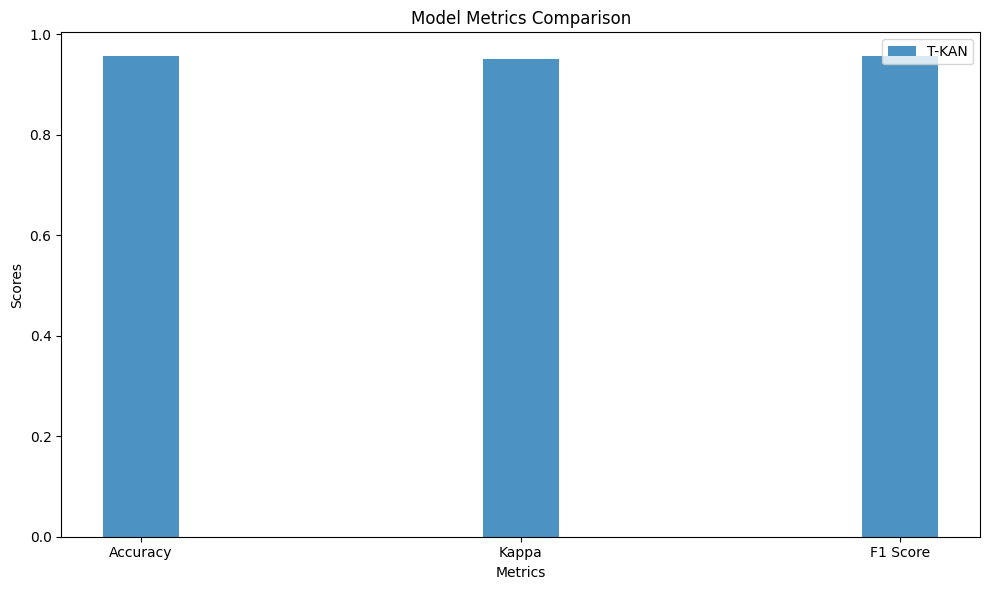

In [13]:
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.2
opacity = 0.8
index = np.arange(len(metrics.keys()))

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Custom colors for each model

for i, model_name in enumerate(Model_Names):
    model_metrics = [metrics['Accuracy'][i], metrics['Kappa'][i], metrics['F1 Score'][i]]
    ax.bar(index + i * bar_width, model_metrics, bar_width,
           alpha=opacity, color=colors[i], label=model_name)

ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Model Metrics Comparison')
ax.set_xticks(index + bar_width * (len(Model_Names) - 1) / 2)
ax.set_xticklabels(metrics.keys())
ax.legend()

plt.tight_layout()
plt.show()